## Purpose

The purpose of this notebook is to perform initial exploratory data analysis on the `appdetail.csv` dataset. It contains information on games our company provides.

Before we proceed, let's re-iterate what we are trying to find out. We want to categorise customers based on a likelihood to purchase a certain game. The game of choice is NieR:Automata$^{TM}$.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd  # For data IO
%matplotlib inline

Let's start with loading the data.

In [5]:
apps = pd.read_csv(
    '../data/raw/appdetail.csv'
)
display(apps.head())
print(apps.shape)

,appid,name,release_date__date,genre_description,categories_description,short_description,about_the_game
0,391220,Rise of the Tomb Raider,"Feb 9, 2016","Action,Adventure","Full controller support,Single-player,Steam Ac...",Rise of the Tomb Raider: 20 Year Celebration i...,"<img src=""https://steamcdn-a.akamaihd.net/stea..."
1,524220,NieR:Automata™,"Mar 17, 2017","Action,RPG,Violent","Partial Controller Support,Single-player,Steam...","NieR: Automata tells the story of androids 2B,...","<img src=""https://steamcdn-a.akamaihd.net/stea..."
2,441830,I am Setsuna,"Jul 19, 2016",RPG,"Full controller support,Single-player,Steam Ac...",Inspired by the timeless classic Chrono Trigge...,"<img src=""https://steamcdn-a.akamaihd.net/stea..."
3,410850,Dragon Quest Heroes,"Dec 3, 2015","Action,RPG","Full controller support,Single-player,Steam Ac...","DRAGON QUEST, one of the most iconic RPG serie...","<img src=""https://%CDN_HOST_MEDIA_SSL%/steam/a..."
4,324510,Boundless,"Nov 13, 2014","Action,Adventure,Early Access,Indie,Massively ...","Co-op,Cross-Platform Multiplayer,Full controll...","Boundless is an epic, single universe voxel sa...","<img src=""https://steamcdn-a.akamaihd.net/stea..."


(145, 7)


In [6]:
display(apps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   appid                   145 non-null    int64 
 1   name                    145 non-null    object
 2   release_date__date      145 non-null    object
 3   genre_description       144 non-null    object
 4   categories_description  144 non-null    object
 5   short_description       51 non-null     object
 6   about_the_game          145 non-null    object
dtypes: int64(1), object(6)
memory usage: 8.1+ KB


None

The data contains details of 145 games. 

The `name` column contains the name of the game; the `release_date__date` column contains the release date for the game (we can convert this column to a datetime, if we need to). The `appid` column contains a unique identifier for each game. We will call these columns "identifiers". 

From the brief look above, the `about_the_game` column may contain a description of the game, but contains string data that will need further preprocessing, based on the HTML tags; the `short_description` contains a short description of the game, perhaps a shorter form of the `about_the_game` description (it containsa significant number of empty columns). The `genre_description` column contains information about the genre of the game (RPG, Action, Advernture, etc.), and it is missing the genre description for one game. We could do something interesting with this column, as it will allow us to find which games are similar to one another based on their descriptions. We will call these columns "descriptors".

Finally, the `categories_description` appears to list the capabilities that the game allows (Co-op play, Cross-Platform play, etc.). We'll call this "capabilities".

### Identifiers

The `release_date__date` contains information about when the games where released. We should check the earliest and latest releases.

In [7]:
apps['release_date__date_dt'] = pd.to_datetime(apps['release_date__date'], format='%b %d, %Y')
print(
    "Earliest release: {} on {};\nlatest release: {} on {}.".format(
        apps.sort_values('release_date__date_dt').iloc[0]['name'],
        apps['release_date__date_dt'].min().strftime('%Y-%m-%d'),
        apps.sort_values('release_date__date_dt').iloc[-1]['name'],
        apps['release_date__date_dt'].max().strftime('%Y-%m-%d'),
    )
)

Earliest release: Dungeon Siege II on 2005-08-16;
latest release: Black The Fall on 2017-07-11.


The data contains information for 145 games released between the 16$^{th}$ of August of 2005 and 11$^{th}$ of July of 2017.

### Capabilities

This column contains more information about the game itself. Let's have a look at the entries in these lists.

In [8]:
apps['categories_description_list'] = apps['categories_description'].apply(
    lambda x: x.split(',')  # Split string by ','
    if x == x  # Ignore NaN values
    else None  # Return None if x is NaN
)
# We can use this new column to find the number of titles 
# with a given genre
apps.explode(
    'categories_description_list'
).value_counts(
    'categories_description_list',
)

categories_description_list
Single-player                 131
Steam Achievements             73
Downloadable Content           60
Full controller support        57
Steam Cloud                    50
Multi-player                   43
Steam Trading Cards            40
Partial Controller Support     26
Steam Leaderboards             18
Co-op                           6
Shared/Split Screen             4
MMO                             3
Stats                           2
Online Multi-Player             2
Online Co-op                    2
Cross-Platform Multiplayer      2
Commentary available            1
Captions available              1
dtype: int64

While the overwhelming majority of these describe how the game plays (whether it has a single player mode, a multi-player mode, etc), it also describes whether the game is a downloadable content.

For the purposes of analysis, we will remove all rows where the title is a DLC. If a player is purchasing a DLC, they likely also have purchased the main game.

In [9]:
mask = apps.dropna(
    subset=['categories_description']  # drop the column with NaN
)['categories_description'].str.contains('Downloadable Content')

apps_noDLC = apps.dropna(
    subset=['categories_description']
)[~mask]

apps_DLC = apps.dropna(
    subset=['categories_description']
)[mask]

apps_rest = apps[apps['categories_description'].isna()]

### Descriptors

Let's have a look at the descriptor columns, starting with the `genre_description` column.

This column contains a list of genres for the game. Let's have a closer look.

In [10]:
apps_noDLC['genre_description'].head()

0                                     Action,Adventure
1                                   Action,RPG,Violent
2                                                  RPG
3                                           Action,RPG
4    Action,Adventure,Early Access,Indie,Massively ...
Name: genre_description, dtype: object

The column has genres separated by commas, which we can esily parse!

In [11]:
apps_noDLC['genre_description_list'] = apps_noDLC['genre_description'].apply(
    lambda x: x.split(',')  # Split string by ','
    if x == x  # Ignore NaN values
    else None  # Return None if x is NaN
)
# Wedo the same as what we did with the categories_description
# column and use this new column to find the number of titles 
# with a given genre
apps_noDLC.explode(
    'genre_description_list'
).value_counts(
    'genre_description_list',
)

genre_description_list
Action                   50
RPG                      29
Adventure                28
Strategy                  7
Casual                    4
Indie                     3
Massively Multiplayer     3
Simulation                3
Early Access              1
Racing                    1
Violent                   1
dtype: int64

Based on the date, our games company has a lot more games it classes as Action games, followed by RPGs, then Adventure games.

Despite some research, there do not appear to be any fixed rules for comparing two games based on their genres. One thing we could do is find how similar any two games are based on how many genres they share in the list of genres between them. For example, Rise of the Tomb Raider is an Action Adventure game, whereas NieR:Automata$^{TM}$ is a Violent Action RPG. Based on this idea, there are 4 genres shared between the 2 games (Action, Adventure, Violent, RPG), and one genre in common (Action), so the genre similarity would be 1/4.

In [12]:
def get_genre_similarity(game1_genres : list, game2_genres: list) -> float:
    """
    Returns a similarity score based on the genres shared between two games.
    
    A game is similar to another if they share a high number of genres between them.
    
    Parameters
    ----------
    
    game1_genres : list
        List containing the genres for game 1
    game2_genres : list
        List containing the genres for game 2
    
    Returns
    -------
    
    similarity : float
        Similarity between two games based on their genres
    
    Examples
    --------
    Game 1 is an Action RPG
    Game 2 is an Action Adventure game
    Similarity = Shared Genres / Combined Genres = 1 / 3 = 0.33
    
    Game 1 is an RPG
    Game 2 is a Casual Simulation game
    Similarity = Shared Genres / Combined Genres = 0 / 3 = 0
    
    Game 1 is an Action RPG
    Game 2 is a Violent Action RPG
    Similarity = Shared Genres / Combined Genres = 2 / 3 = 0.66
    """
    set_genres_game1 = set(game1_genres)
    set_genres_game2 = set(game2_genres)
    
    combined_genres = set_genres_game1 | set_genres_game2
    shared_genres = set_genres_game1.intersection(set_genres_game2)
    
    return len(shared_genres)/len(combined_genres)

To re-iterate, we are looking for games similar to NieR:Automata$^{TM}$.

In [13]:
apps_noDLC['genre_sim_NieR'] = apps_noDLC['genre_description_list'].apply(
    lambda genres: get_genre_similarity(
        genres,
        apps_noDLC[apps_noDLC['appid'] == 524220]['genre_description_list'].values[0]  # NieR
    ) if genres else None
)

Let's check the results of our new column, to see if they make sense. We should also drop the row with NieR:Automata$^{TM}$ when we check the data.

First, we check for the distribution of values.

In [14]:
apps_noDLC[~apps_noDLC['name'].str.contains('NieR')]['genre_sim_NieR'].value_counts()

0.333333    35
0.250000    24
0.000000    14
0.666667     5
0.500000     2
0.200000     2
0.285714     1
Name: genre_sim_NieR, dtype: int64

<AxesSubplot:ylabel='Frequency'>

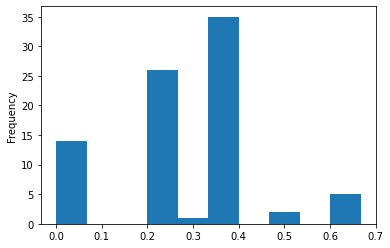

In [15]:
apps_noDLC[~apps_noDLC['name'].str.contains('NieR')]['genre_sim_NieR'].plot(kind='hist')

In [16]:
(apps_noDLC[~apps_noDLC['name'].str.contains('NieR')]['genre_sim_NieR'].value_counts(
    normalize=True
)*100).round(2)

0.333333    42.17
0.250000    28.92
0.000000    16.87
0.666667     6.02
0.500000     2.41
0.200000     2.41
0.285714     1.20
Name: genre_sim_NieR, dtype: float64

As the data shows, about 29% (24 titles) of the games released between 2005 and 2017 are 1/4 similar to NieR, while 6% (5 titles) are 2/3 similar. Let's check them. 

In [17]:
apps_noDLC.query('genre_sim_NieR == 2/3')

,appid,name,release_date__date,genre_description,categories_description,short_description,about_the_game,release_date__date_dt,categories_description_list,genre_description_list,genre_sim_NieR
3,410850,Dragon Quest Heroes,"Dec 3, 2015","Action,RPG","Full controller support,Single-player,Steam Ac...","DRAGON QUEST, one of the most iconic RPG serie...","<img src=""https://%CDN_HOST_MEDIA_SSL%/steam/a...",2015-12-03,"[Full controller support, Single-player, Steam...","[Action, RPG]",0.666667
6,340170,FINAL FANTASY TYPE-0 HD,"Aug 18, 2015","Action,RPG","Full controller support,Single-player,Steam Ac...",FINAL FANTASY TYPE-0 HD brings an immersive wo...,"Step into the fray as Class Zero, a group of s...",2015-08-18,"[Full controller support, Single-player, Steam...","[Action, RPG]",0.666667
7,337000,Deus Ex: Mankind Divided™,"Aug 23, 2016","Action,RPG","Full controller support,Single-player,Steam Ac...","Now an experienced covert operative, Adam Jens...","<img src=""https://steamcdn-a.akamaihd.net/stea...",2016-08-23,"[Full controller support, Single-player, Steam...","[Action, RPG]",0.666667
17,238010,Deus Ex: Human Revolution - Director's Cut,"Oct 25, 2013","Action,RPG","Captions available,Commentary available,Partia...",NaN,"You play Adam Jensen, an ex-SWAT specialist wh...",2013-10-25,"[Captions available, Commentary available, Par...","[Action, RPG]",0.666667
28,39160,Dungeon Siege III,"Jun 20, 2011","Action,RPG","Co-op,Multi-player,Single-player,Steam Achieve...",Fight hordes of dangerous creatures in a mysti...,For centuries legionnaires have protected the ...,2011-06-20,"[Co-op, Multi-player, Single-player, Steam Ach...","[Action, RPG]",0.666667


Ignoring NieR itself, the other games like it are from the Deus Ex franchise, a franchise following a hacker in a dystopian futuristic world (much like NieR is). The other similar games, Final Fantasy Type-0, Dragon Quest Heroes, and Dungeon Siege III, are a slightly less compatible in the gameplay and visual aspects (NieR is set in a dystopian cyberpunk world, the others are set in fantasy worlds).

In [18]:
apps_noDLC.query('genre_sim_NieR == 0')

,appid,name,release_date__date,genre_description,categories_description,short_description,about_the_game,release_date__date_dt,categories_description_list,genre_description_list,genre_sim_NieR
11,230330,FINAL FANTASY® XI: Ultimate Collection Seekers...,"Apr 19, 2013",Massively Multiplayer,MMO,NaN,BEGIN A NEW JOURNEY WITH THE COMPLETE EDITION ...,2013-04-19,[MMO],[Massively Multiplayer],0.0
16,499520,The Turing Test,"Aug 30, 2016",Adventure,"Full controller support,Single-player,Steam Ac...",The Turing Test is a challenging first-person ...,The Turing Test is a challenging first-person ...,2016-08-30,"[Full controller support, Single-player, Steam...",[Adventure],0.0
30,421740,Goetia,"Apr 14, 2016","Adventure,Indie","Single-player,Steam Achievements,Steam Cloud,S...",Goetia is a point &amp; click adventure where ...,The ruins of any village are the silent testam...,2016-04-14,"[Single-player, Steam Achievements, Steam Clou...","[Adventure, Indie]",0.0
33,9420,Supreme Commander: Forged Alliance,"Sep 28, 2011",Strategy,"Multi-player,Single-player",NaN,The last days of man are at hand.. Two years a...,2011-09-28,"[Multi-player, Single-player]",[Strategy],0.0
34,9350,Supreme Commander,"Sep 28, 2011",Strategy,"Multi-player,Single-player",NaN,"For a thousand years, three opposing forces ha...",2011-09-28,"[Multi-player, Single-player]",[Strategy],0.0
35,40100,Supreme Commander 2,"Mar 1, 2010",Strategy,"Multi-player,Single-player,Stats,Steam Achieve...","Includes 47 Steam achievements, leaderboards, ...","In Supreme Commander 2, players will experienc...",2010-03-01,"[Multi-player, Single-player, Stats, Steam Ach...",[Strategy],0.0
46,540840,Lara Croft GO,"Dec 4, 2016",Adventure,"Full controller support,Single-player,Steam Ac...",Lara Croft GO is a turn based puzzle-adventure...,Lara Croft GO is a turn based puzzle-adventure...,2016-12-04,"[Full controller support, Single-player, Steam...",[Adventure],0.0
54,200010,Quantum Conundrum,"Jun 21, 2012","Casual,Strategy","Full controller support,Single-player,Steam Ac...",Find and rescue your uncle by using his newest...,"When you, as a young boy, are dropped off to v...",2012-06-21,"[Full controller support, Single-player, Steam...","[Casual, Strategy]",0.0
57,34600,Order of War™,"Sep 17, 2009",Strategy,Single-player,NaN,"October 22, 2009 - Update <br>\t\t\t\t\t<a hre...",2009-09-17,[Single-player],[Strategy],0.0
58,427820,Hitman GO: Definitive Edition,"Feb 23, 2016",Strategy,"Full controller support,Single-player,Steam Ac...","Hitman GO is a simple to play, but difficult t...","Hitman GO is a simple to play, but difficult t...",2016-02-23,"[Full controller support, Single-player, Steam...",[Strategy],0.0


Games with a lower similarity share fewer genres, like Indie (for Black The Fall) or Racing (like Sleeping Dogs). While these games share genres (Action and Adventure), they also have other genres that may be more appealing to certain customers, i.e. a customer might be more interested in the racing aspect of a game, and less interested in the Violent side of it, which may lead them to choose Sleeping Dogs over NieR.

These aspects serve to give us an idea of how customer behavior can affect their purchase preferences, and thus might give us a better idea as to which customers to advertise to. Of course, since we are going to be linking this to customer behaviour, we are making the __assumption__ that customers tend to have preferences in the games they play, and might deviate very little from a core set of genres they prefer (i.e. a customer who prefers RPGs like Final Fantasy VII might try an Action RPG like Dragon Quest Heroes, but might not so inclined to try a Casual game like Season of Mystery).

Despite this, we now have a data point that will help us develop a better understanding of customer behaviour. We can use this new data to find which customers are more likely to buy our new game, based on both recency/frequency metrics (which we calculated in the last Notebook), as well as their game preferences.

The next Notebook will tackle simple clustering to answer this question.

In [25]:
# We are saving the dat as a JSON, though it would
# be just as valid to save it as a CSV.
apps_noDLC.drop(
    [
        'categories_description_list', # we don't need these
        'genre_description_list',
        'release_date__date_dt',
    ],
    axis=1
).to_json(
    '../data/processed/apps_with_genresim.json'
)